Pankajan T.
190428D

In [1]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np


(-0.5, 479.5, 639.5, -0.5)

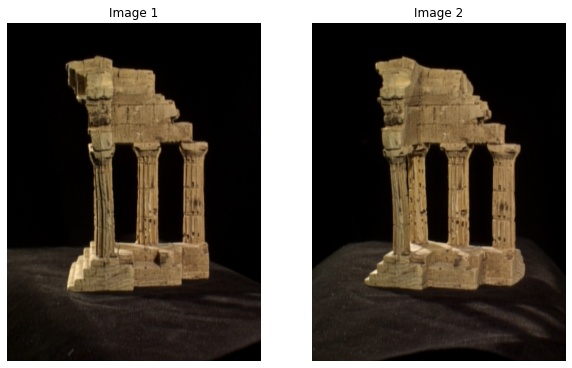

In [2]:


f = open(r'templeSR_par.txt', 'r')


n = int(f.readline())

l = f.readline().split()
im1_f = l[0]
K1 = np.array([float(i) for i in l[1:10]]).reshape((3,3))
R1 = np.array([float(i) for i in l[10:19]]).reshape((3,3))
t1 = np.array([float(i) for i in l[19:22]]).reshape((3,1))

l = f.readline().split()
im2_f = l[0]
K2 = np.array([float(i) for i in l[1:10]]).reshape((3,3))
R2 = np.array([float(i) for i in l[10:19]]).reshape((3,3))
t2 = np.array([float(i) for i in l[19:22]]).reshape((3,1))

im1 = cv.imread( im1_f, cv.IMREAD_COLOR)

im2 = cv.imread( im2_f, cv.IMREAD_COLOR)



fig, ax = plt.subplots(1, 2, figsize = (10,8))
im1_n = np.rot90(cv.cvtColor(im1, cv.COLOR_BGR2RGB),k=1)
ax[0].imshow(im1_n)
ax[0].set_title('Image 1')
ax[0].axis('off')
im2_n = np.rot90(cv.cvtColor(im2, cv.COLOR_BGR2RGB),k=1)
ax[1].imshow(im2_n)
ax[1].set_title('Image 2')
ax[1].axis('off')

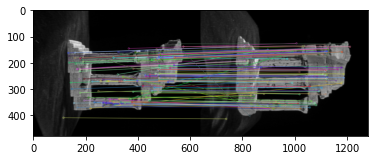

(<matplotlib.image.AxesImage at 0x2afd2807940>, None)

In [10]:

img1 = cv.imread('templeSR0001.png',cv.IMREAD_GRAYSCALE)          
img2 = cv.imread('templeSR0002.png',cv.IMREAD_GRAYSCALE) 

sift = cv.SIFT_create()

kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)

bf = cv.BFMatcher()
matches = bf.knnMatch(des1,des2,k=2)

gd = []
for m,n in matches:
    if m.distance < 0.75*n.distance:
        gd.append([m])

img3 = cv.drawMatchesKnn(img1,kp1,img2,kp2,gd,None,flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(img3),plt.show()

In [8]:
kp1, decs1 = sift.detectAndCompute(im1, None)
kp2, decs2 = sift.detectAndCompute(im2, None)
points1 = np.array(cv.KeyPoint_convert(kp1))
print("Points 1 =",points1)
points2 = np.array(cv.KeyPoint_convert(kp2))
print("Points 2 =",points2)
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 100)
flann = cv.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(decs1, decs2, k=2)

Points 1 = [[ 13.0532055 117.93448  ]
 [ 19.927507  123.60333  ]
 [108.252266   96.32402  ]
 ...
 [575.7586    139.68608  ]
 [575.9352    159.6251   ]
 [578.3364    184.21379  ]]
Points 2 = [[ 41.017296 330.72073 ]
 [ 58.990788 194.78354 ]
 [ 58.990788 194.78354 ]
 ...
 [571.19086  173.26408 ]
 [571.19086  173.26408 ]
 [574.2256   165.52284 ]]


In [11]:
gd = []
pts1 = []
pts2 = []
for i, (m,n) in enumerate(matches):
    if m.distance < 0.7*n.distance:
        gd.append(m)
        pts1.append(kp1[m.queryIdx].pt)
        pts2.append(kp2[m.trainIdx].pt)

pts1 = np.array(pts1)
pts2 = np.array(pts2)
F, mask = cv.findFundamentalMat(pts1, pts2, cv.FM_RANSAC)
print("Fundamental matrix =",F)
E = K2.T @ F @ K1 
print("Essential Matrix =",E)

Fundamental matrix = [[ 5.71895643e-07  1.18498989e-05 -2.83221465e-02]
 [-3.51632090e-06  3.68600981e-07  4.43087197e-04]
 [ 2.59539085e-02 -4.52098841e-03  1.00000000e+00]]
Essential Matrix = [[ 1.32200321e+00  2.74915089e+01 -3.83503665e+01]
 [-8.15778840e+00  8.58239765e-01 -8.07155954e-01]
 [ 3.84033729e+01 -1.29324673e+00 -2.59770082e-02]]


In [12]:
retval, R, t, mask = cv.recoverPose(E, pts1, pts2, K1)
R_t_1 = np.concatenate((R1,t1), axis=1) 
R2_ = R1 @ R
t2_ = R1 @ t
R_t_2 = np.concatenate((R2_,t2_), axis=1) 
P1 = K1 @ np.hstack((R1, t1))
P2_ = K2 @ R_t_2 
print("Second camera matrix =",P2_)

Second camera matrix = [[ 1.33053310e+02  1.54352811e+03  5.32102268e+01 -1.28802804e+03]
 [ 1.53260026e+03 -7.73585297e+01 -1.85654800e+02  1.28543652e+02]
 [ 5.45666605e-02  2.24698157e-01 -9.72899387e-01  3.83260914e-01]]


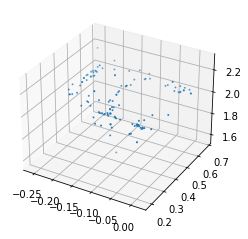

In [14]:
pnt4d = cv.triangulatePoints(P1,P2_, pts1.T, pts2.T)
pnt4d /= pnt4d[3,:]
X = pnt4d[0,:]
Y = pnt4d[1,:]
Z = pnt4d[2,:]
fig = plt.figure(1)
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X, Y, Z, s=1, cmap='gray')
plt.show()